In [1]:
# from tensorflow.keras.models import load_model
import numpy as np
import tensorflow as tf
from neurite_sandbox.tf.models import labels_to_labels
from neurite_sandbox.tf.utils.augment import add_outside_shapes
from neurite.tf.utils.augment import draw_perlin_full

import tensorflow.keras.layers as KL
import voxelmorph as vxm


import argparse
from tensorflow.keras.callbacks import ReduceLROnPlateau
import pathlib
# import surfa as sf
import re
import json
from keras import backend as K
import param_3d
import data
import model_3d
from data_3d import *
import scipy.ndimage as ndimage

import nibabel as nib
from tqdm import tqdm

from utils import *
from help import *

/cbica/home/dadashkj/neurite/neurite/__init__.py:33: FutureWarning: The default backend will soon be changing to 'pytorch'. If you prefer to use TensorFlow, please set the NEURITE_BACKEND environment variable to 'tensorflow'.
  backend = py.utils.get_backend()
/cbica/home/dadashkj/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Issue loading cv2


In [19]:
folder_path = "/cbica/home/dadashkj/neuroconnlab_pig_data/dwi_PigAnatomical/7646/anat"
geom_data = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).geom
pig_anat = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).reshape([param_3d.img_size_192,]*3).data
pig_brain = sf.load_volume(os.path.join(folder_path, 'anat_brain.nii.gz')).reshape([param_3d.img_size_192,]*3).data
pig_brain_mask = sf.load_volume(os.path.join(folder_path, 'anat_brain_mask.nii.gz')).reshape([param_3d.img_size_192,]*3).data

[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


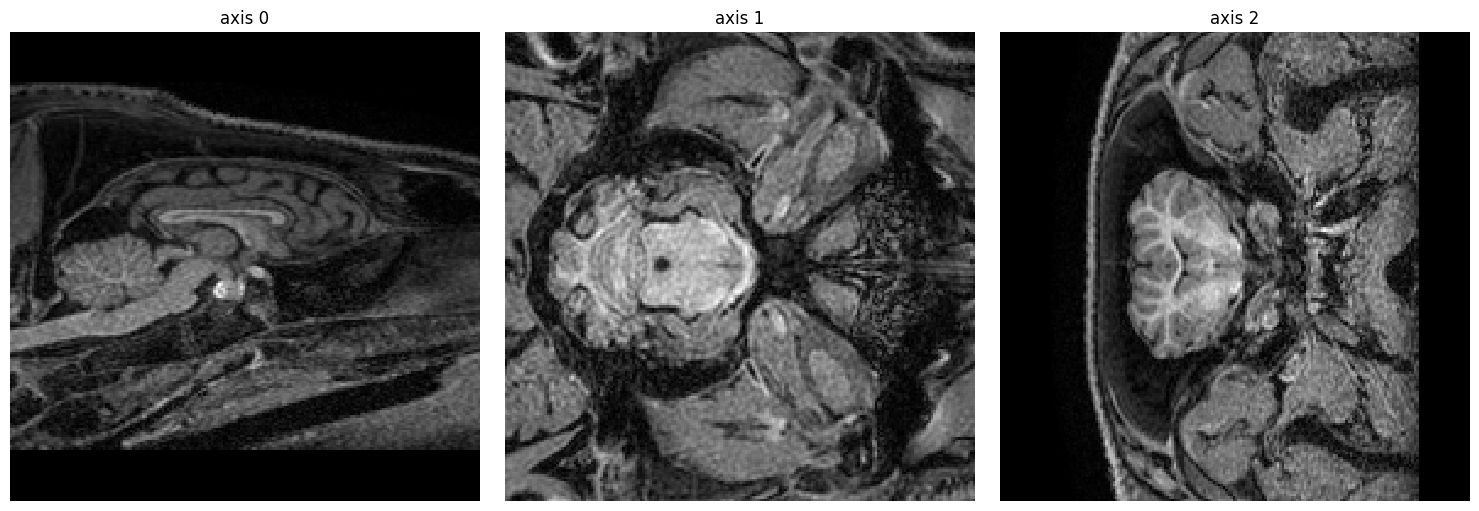

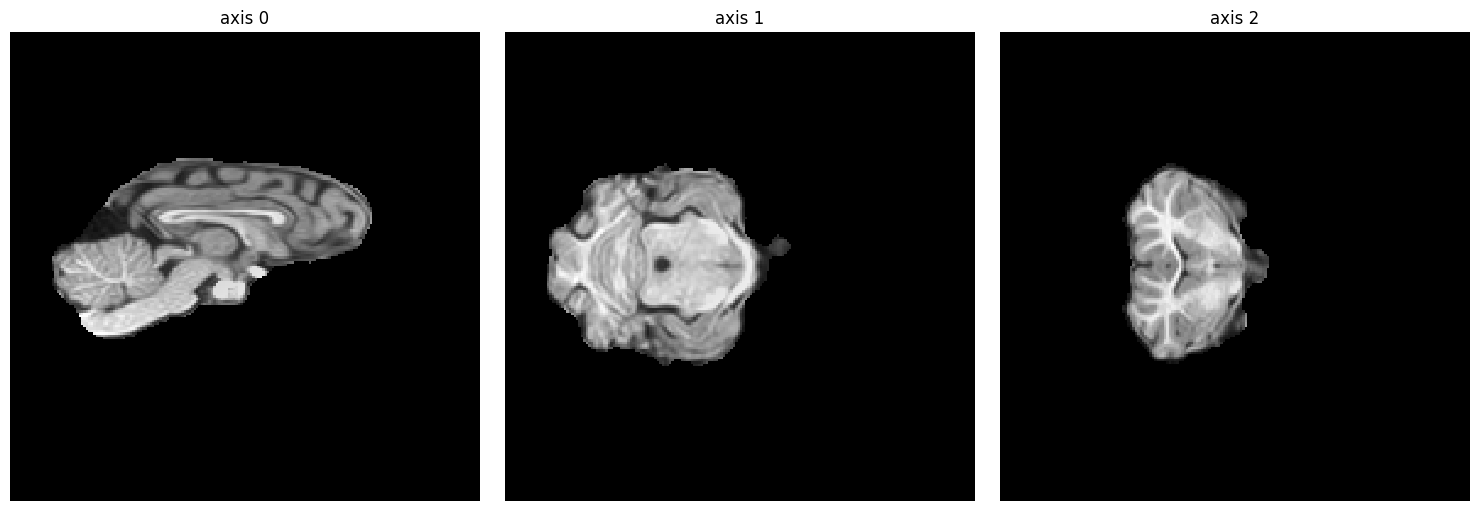

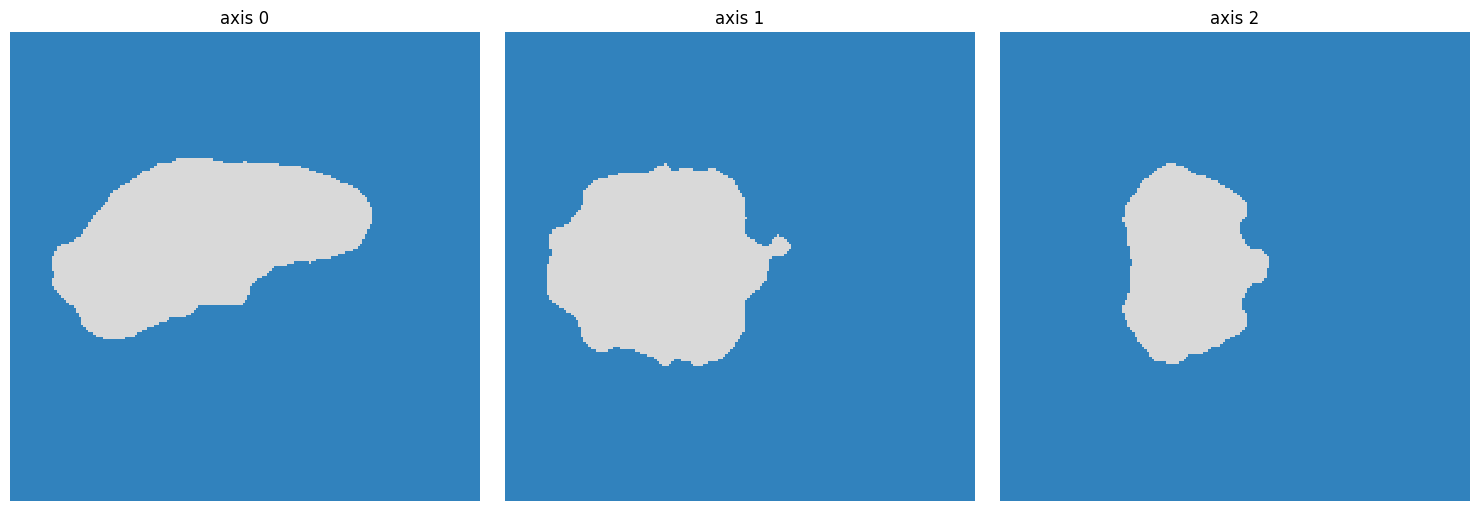

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [15]:
ne.plot.volume3D(pig_anat)
ne.plot.volume3D(pig_brain)
ne.plot.volume3D(pig_brain_mask,cmaps=['tab20c'])

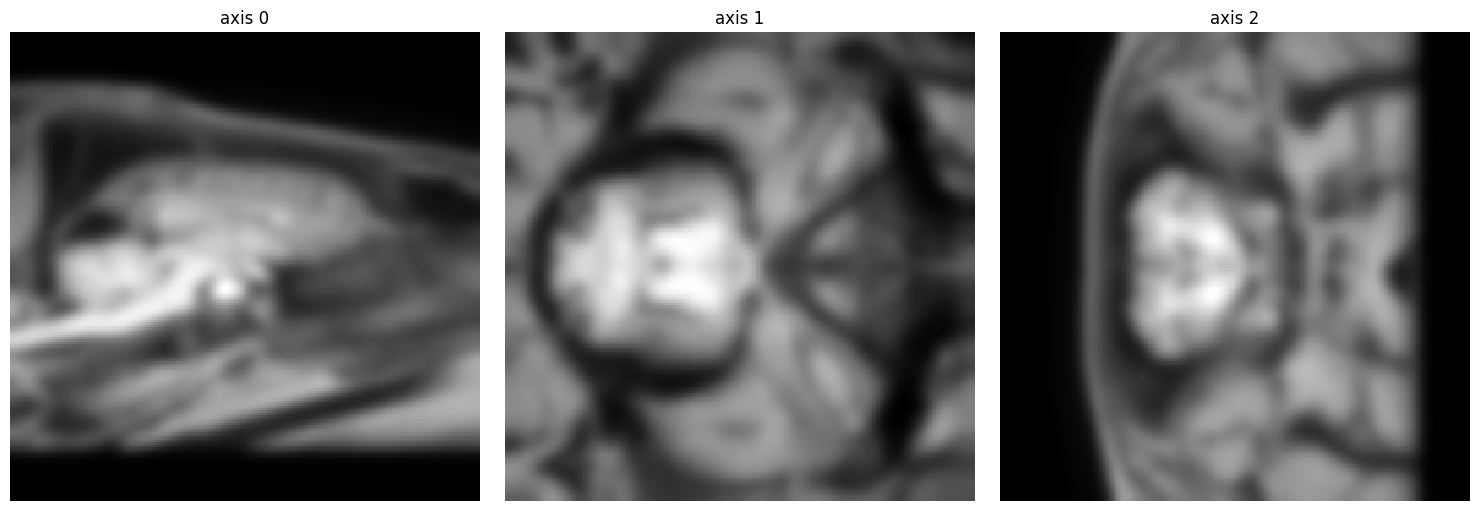

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [20]:
import numpy as np
import os
from sklearn.mixture import GaussianMixture
from scipy.ndimage import gaussian_filter
# Smooth the anatomy using Gaussian filter (with a chosen sigma)
pig_skull = np.copy(pig_anat)
pig_skull[pig_brain_mask == 1] = 0

sigma = 3  # Adjust sigma for desired smoothing effect
smoothed_anat = gaussian_filter(pig_anat, sigma=sigma)
# Flatten the brain and non-brain data for GMM
brain_data = pig_brain.flatten().reshape(-1, 1)
non_brain_data = pig_skull.flatten().reshape(-1, 1)

ne.plot.volume3D(smoothed_anat)

In [21]:
k1 = 5
k2=5
# Apply GMM for brain regions (assumes 29 brain regions to be classified)
gmm_brain = GaussianMixture(n_components=k1, random_state=42)
gmm_brain.fit(brain_data)  # Fit GMM on the brain data

# Apply GMM for non-brain regions (background and other tissues)
gmm_non_brain = GaussianMixture(n_components=k2, random_state=42)  # 0 for background, 30-40 for other tissues
gmm_non_brain.fit(non_brain_data)  # Fit GMM on the non-brain data

# Predict the components (labels) for brain and non-brain regions
predicted_brain_labels = gmm_brain.predict(brain_data)
predicted_non_brain_labels = gmm_non_brain.predict(non_brain_data)
predicted_non_brain_labels = shift_non_zero_elements(predicted_non_brain_labels,k1)

predicted_brain_labels = predicted_brain_labels.reshape((192,192,192))
predicted_non_brain_labels = predicted_non_brain_labels.numpy().reshape((192,192,192))
predicted_anat_labels = predicted_brain_labels+predicted_non_brain_labels

In [22]:
pig_brain_map = [predicted_anat_labels]

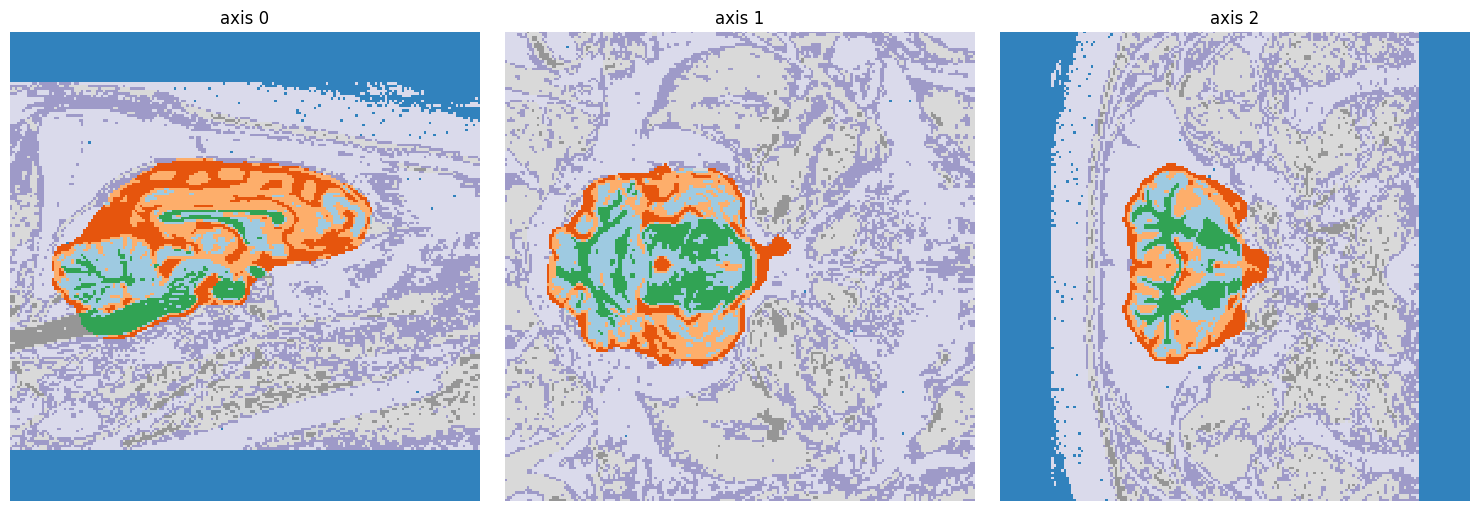

In [23]:
# a = predicted_brain_labels.reshape((192,192,192))
ne.plot.volume3D(predicted_anat_labels,cmaps=['tab20c'])
nib.save(nib.Nifti1Image(predicted_anat_labels.astype(np.int32), np.eye(4)), "data/pig_gmm.nii.gz")
# a = predicted_non_brain_labels.reshape((192,192,192))
# ne.plot.volume3D(a,cmaps=['tab20c'])
# ne.plot.volume3D(predicted_brain_labels,cmaps=['tab20c'])

In [8]:
predicted_anat_labels.shape

(192, 192, 192)

In [9]:
with open("params_gmm_192.json", "r") as json_file:
    config = json.load(json_file)
pig_brain_map = [predicted_anat_labels]
gen=generator_brain_window_Net(pig_brain_map,param_3d.img_size_192)



model_pig_config = config["pig_48"]
model_shapes_config = config["shapes"]
model3_config = config["labels_to_image_model_48"]
model3_config["labels_out"] = {int(key): value for key, value in model3_config["labels_out"].items()}
model3_config["in_shape"]=[ param_3d.img_size_192, param_3d.img_size_192, param_3d.img_size_192]
model_pig_config["in_shape"]=[ param_3d.img_size_192, param_3d.img_size_192, param_3d.img_size_192]
model_shapes_config["in_shape"]=[ param_3d.img_size_192, param_3d.img_size_192, param_3d.img_size_192]

model_pig = create_model(model_pig_config)
model_shapes = create_model(model_shapes_config)

labels_to_image_model = create_model(model3_config)

fragment = next(gen)
# _, fg = model_pig(fragment)


In [10]:
fragment.shape

(1, 192, 192, 192, 1)

2024-12-28 12:11:03.883280: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8201


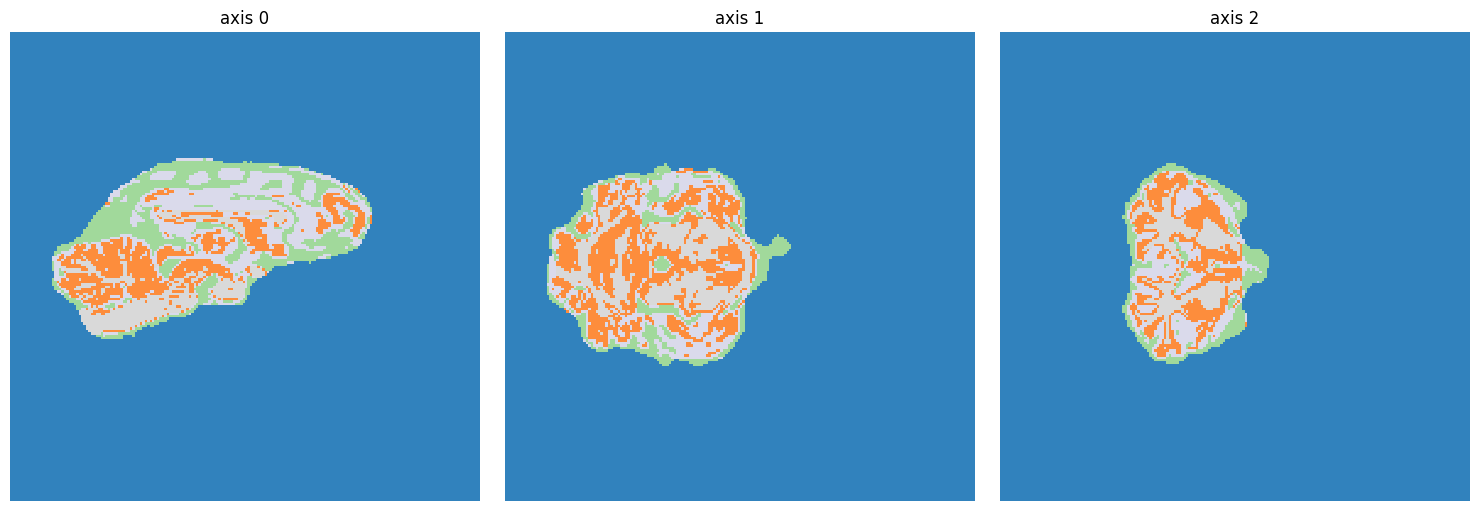

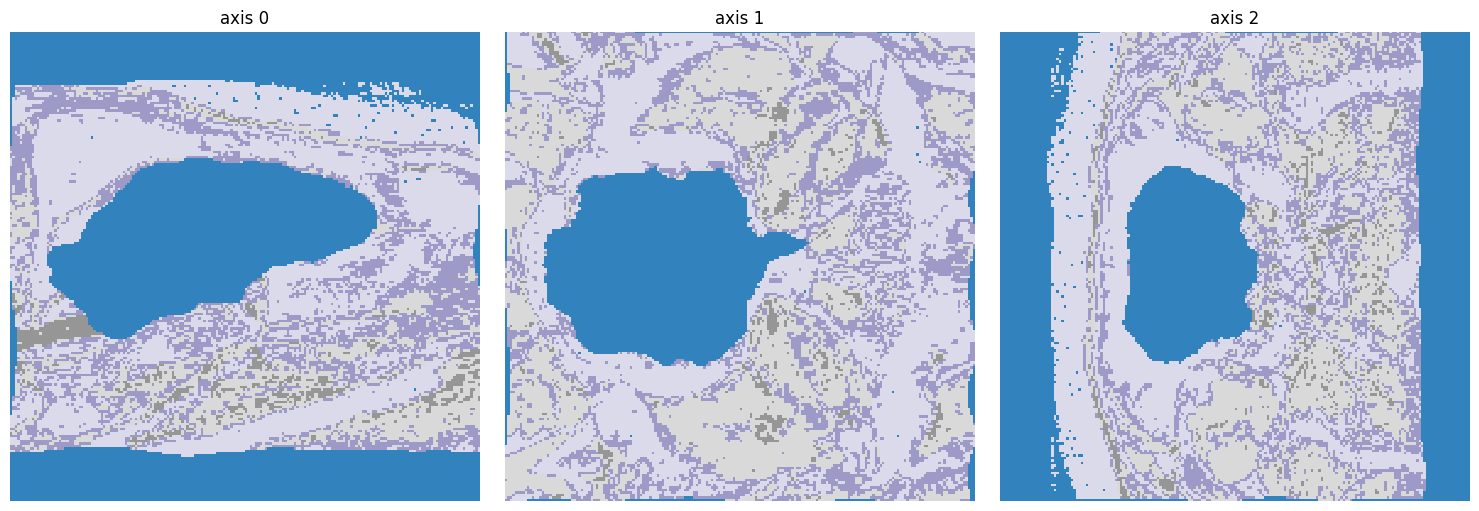

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [11]:
a = fragment[0, ...,0] 
fg_mask = a <6
fragment_brain = tf.where(fg_mask, a, 0)
_, fg = model_pig(fragment_brain[None,...,None])
ne.plot.volume3D(fg[0,...,0],cmaps=['tab20c'])

a = fragment[0, ...,0] 
bg_mask = (a > 5) | (a == 0)
fragment_bg = tf.where(bg_mask, a, 0)
_, bg = model_shapes(fragment_bg[None,...,None])
ne.plot.volume3D(bg[0,...,0],cmaps=['tab20c'])

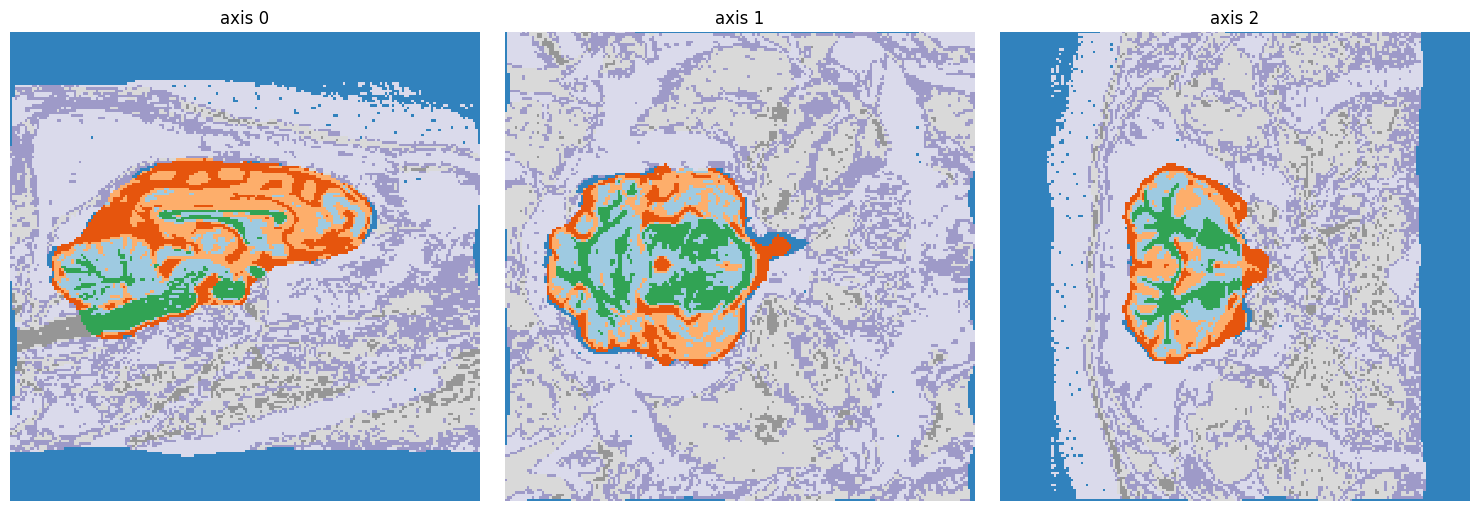

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [12]:
result = fg[0,...,0] + bg[0,...,0] * tf.cast(fg[0,...,0] == 0,tf.int32)
ne.plot.volume3D(result,cmaps=['tab20c'])


In [15]:
bg.shape

TensorShape([1, 192, 192, 192, 1])

(1, 192, 192, 192, 1)


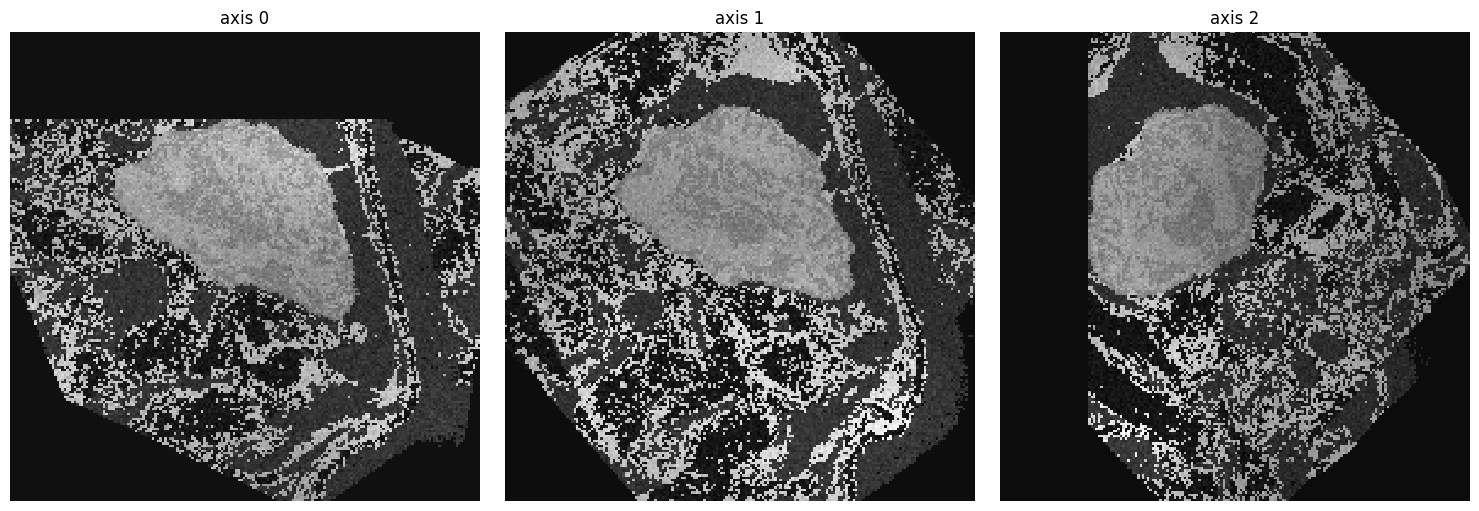

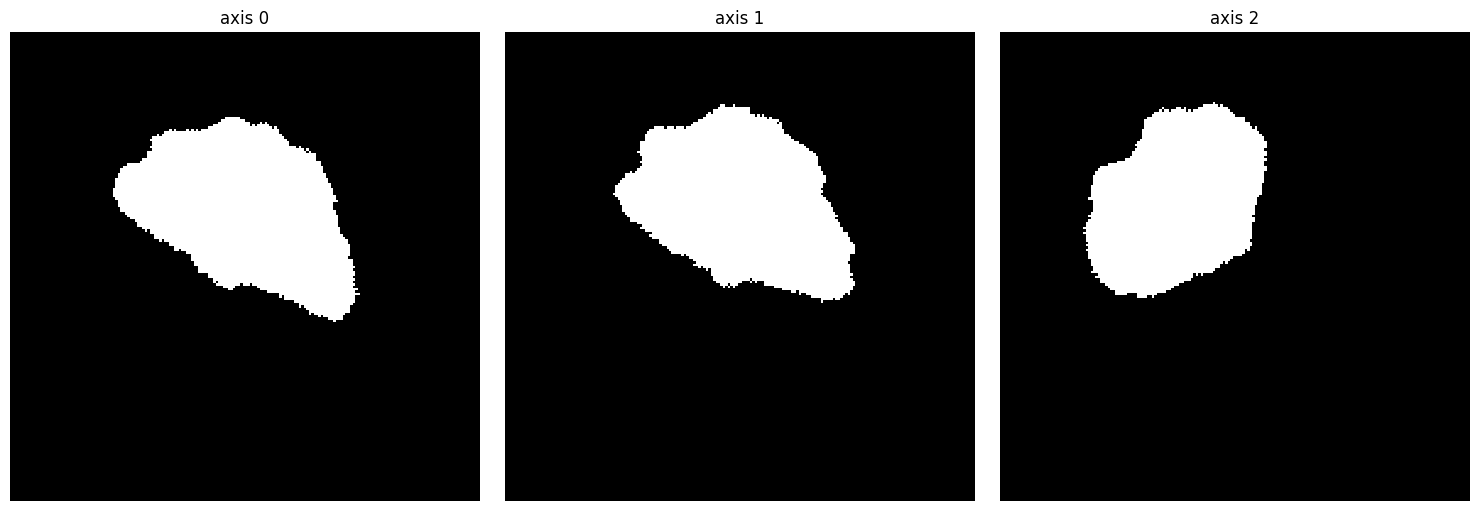

(1, 192, 192, 192, 1)


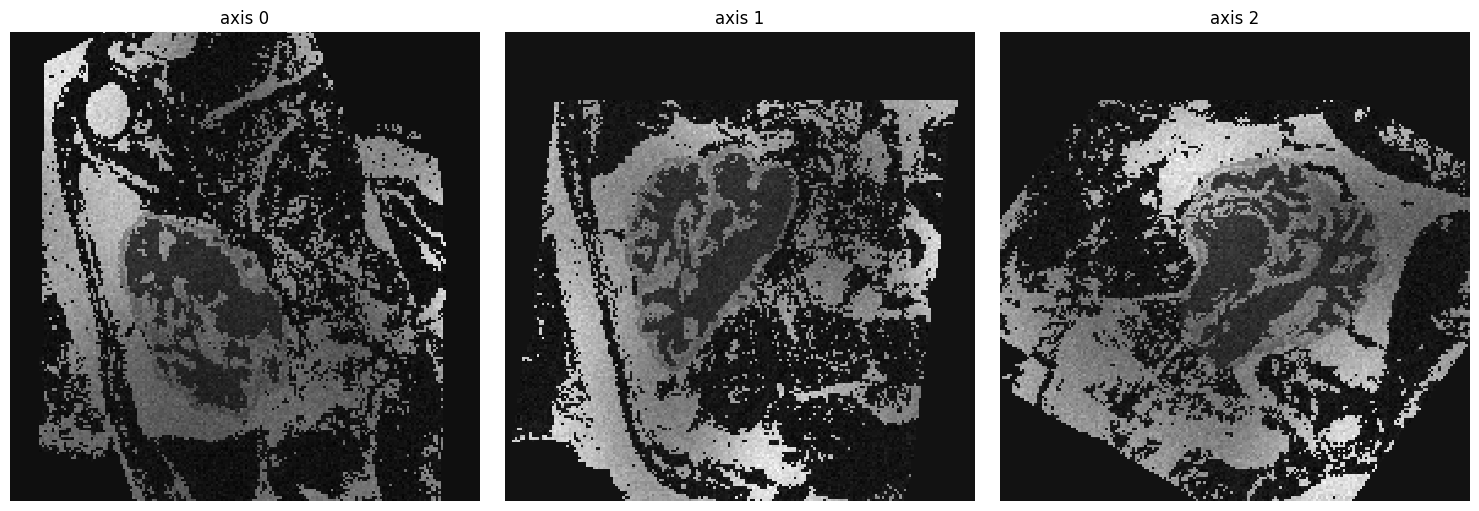

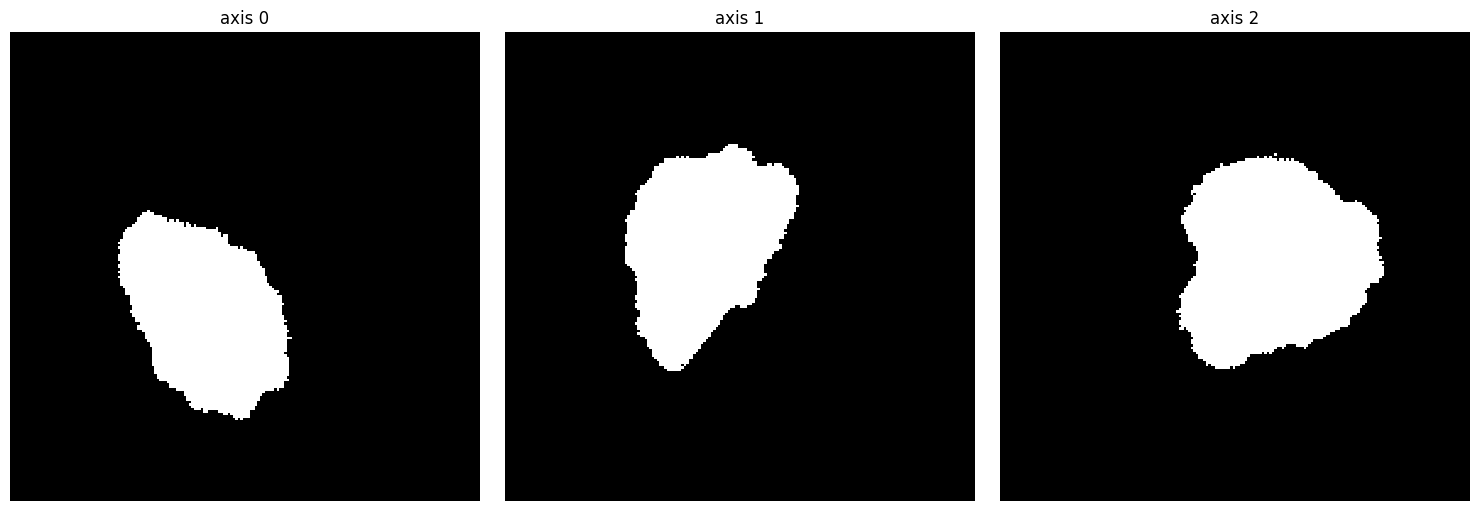

(1, 192, 192, 192, 1)


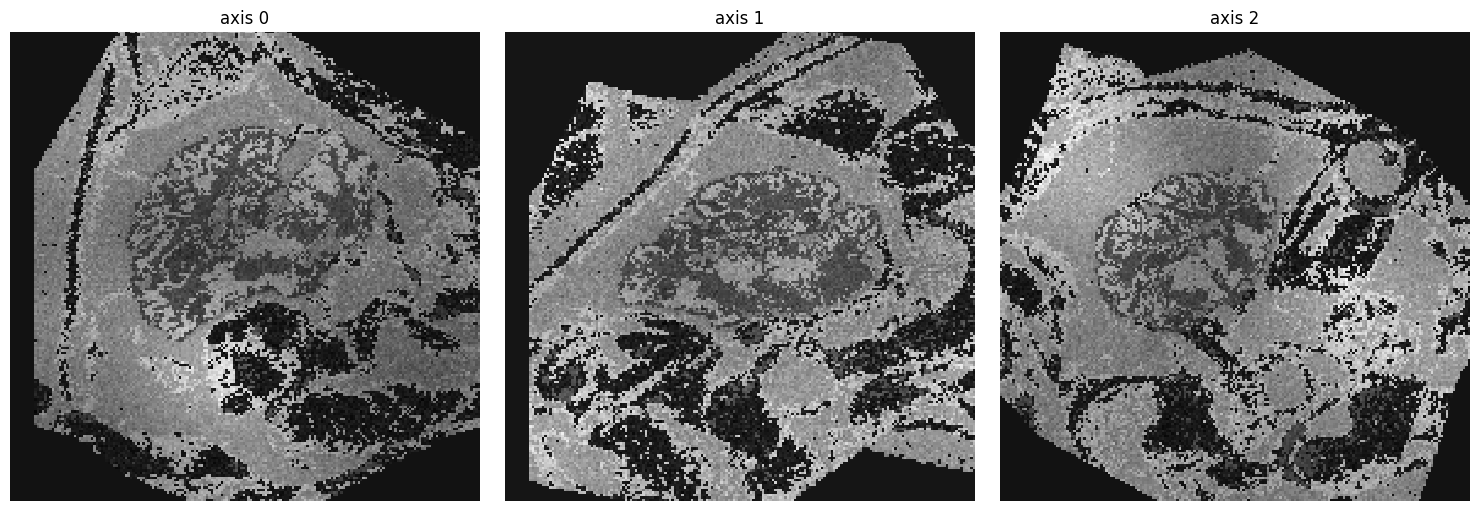

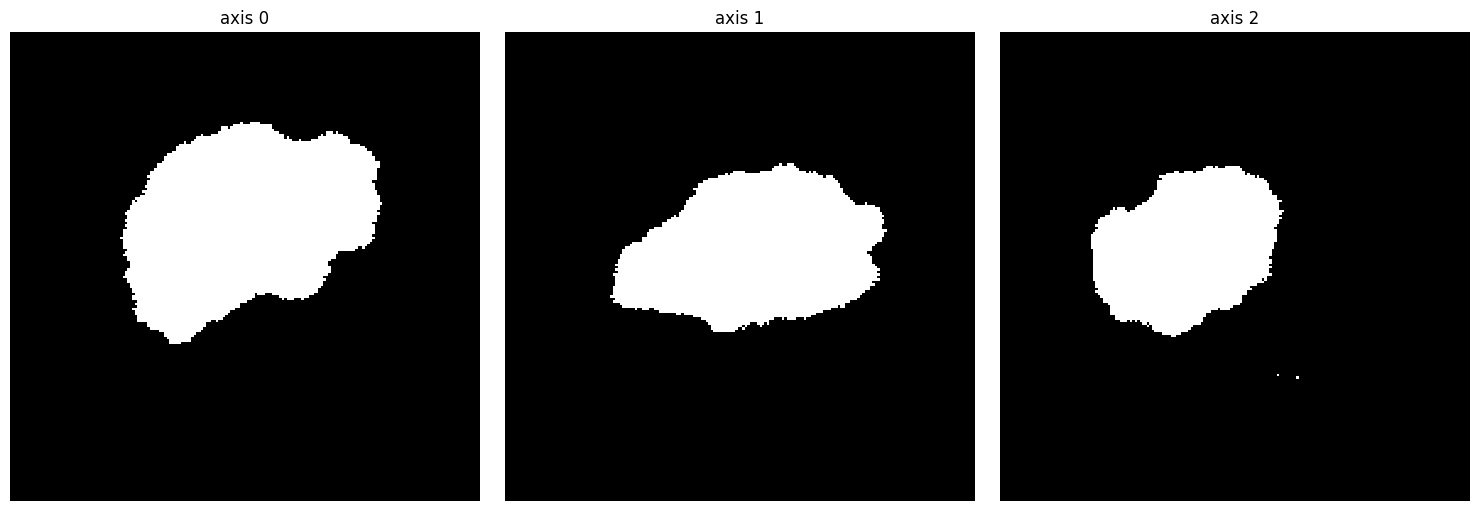

(1, 192, 192, 192, 1)


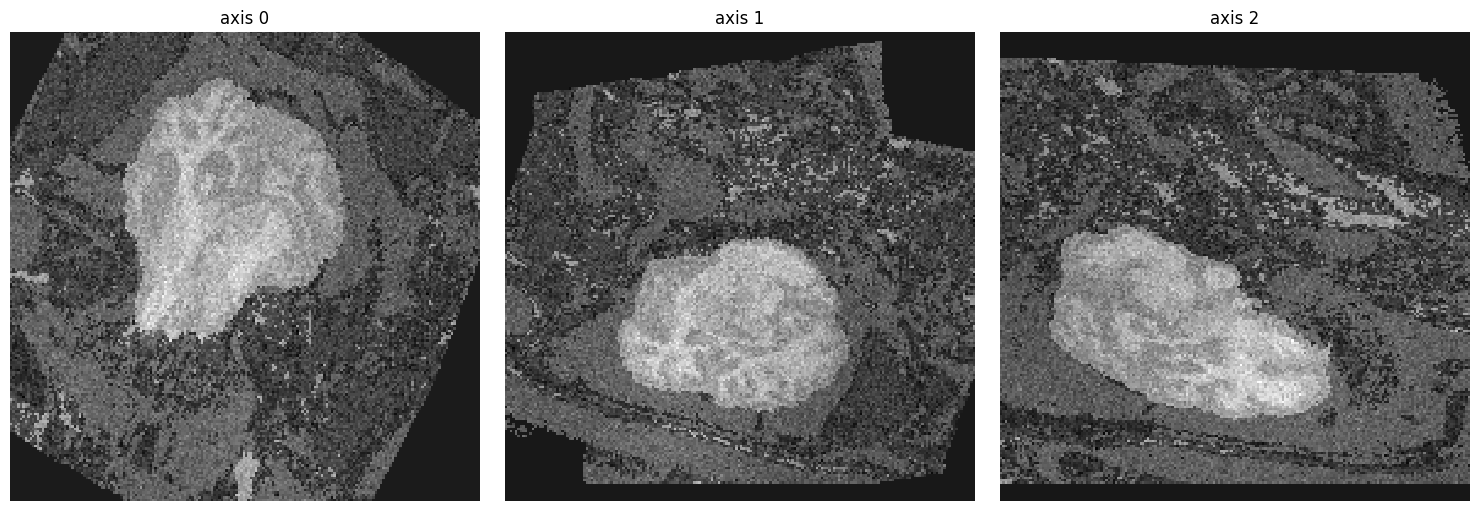

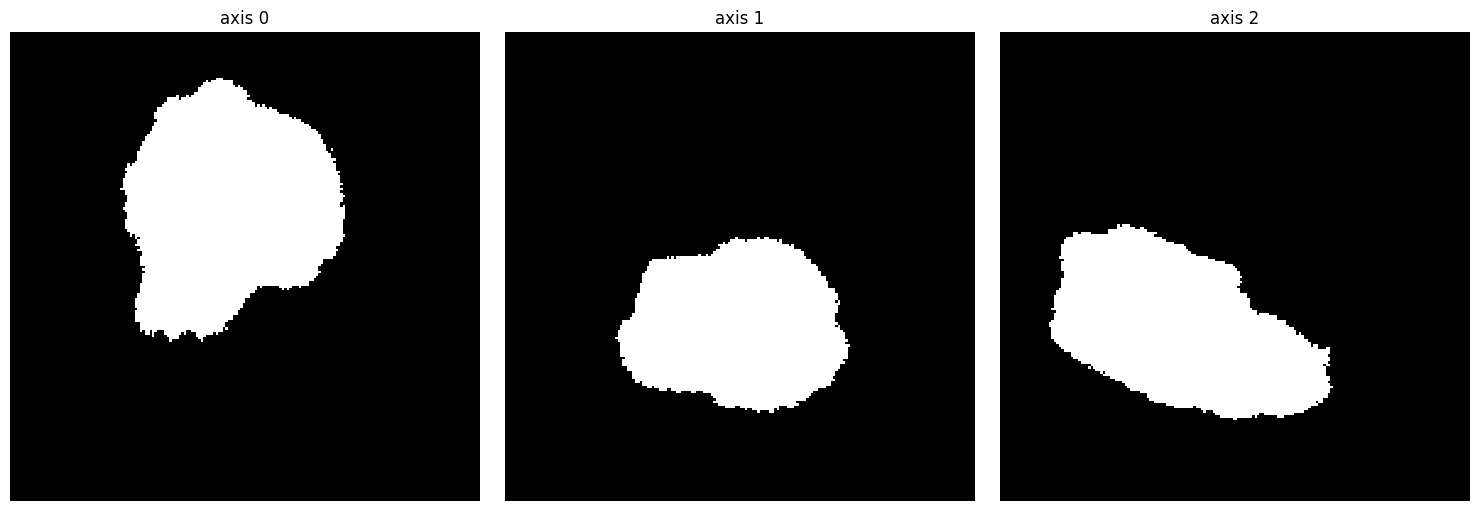

(1, 192, 192, 192, 1)


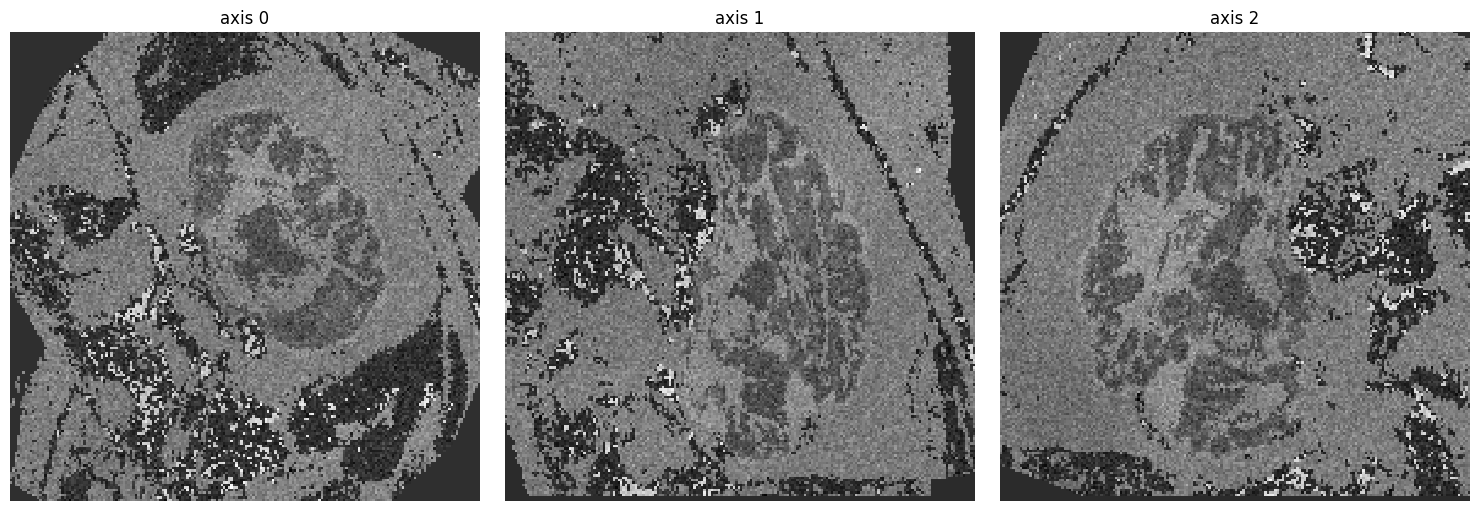

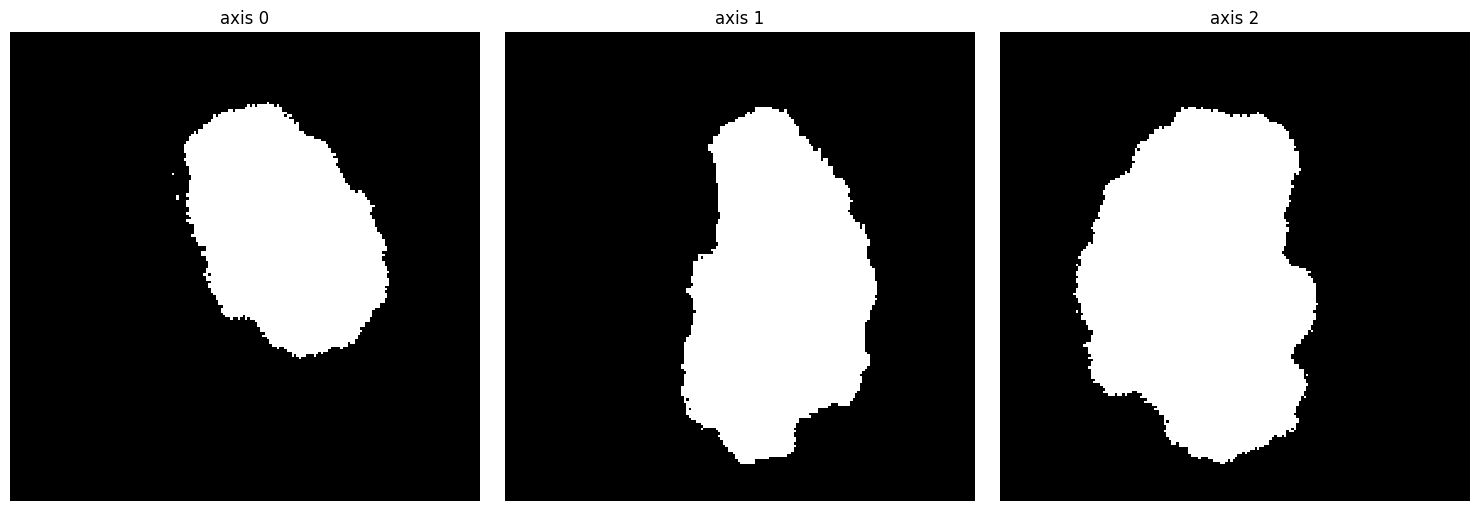

In [21]:
for i in range(5):
    labels_to_image_model = create_model(model3_config)
    generated_img, y = labels_to_image_model(result[None,...,None])
    
    print(generated_img.shape)
    z=np.argmax(y,axis=-1)
    ms = np.mean(np.column_stack(np.nonzero(z[0])), axis=0).astype(int)
    
    ne.plot.volume3D(generated_img,slice_nos=ms);
    ne.plot.volume3D(np.argmax(y,axis=-1),slice_nos=ms);

In [25]:
fragment.shape

(1, 192, 192, 192, 1)

[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!
[DEBUG] NiftiArrayIO.load(): no header extensions found!


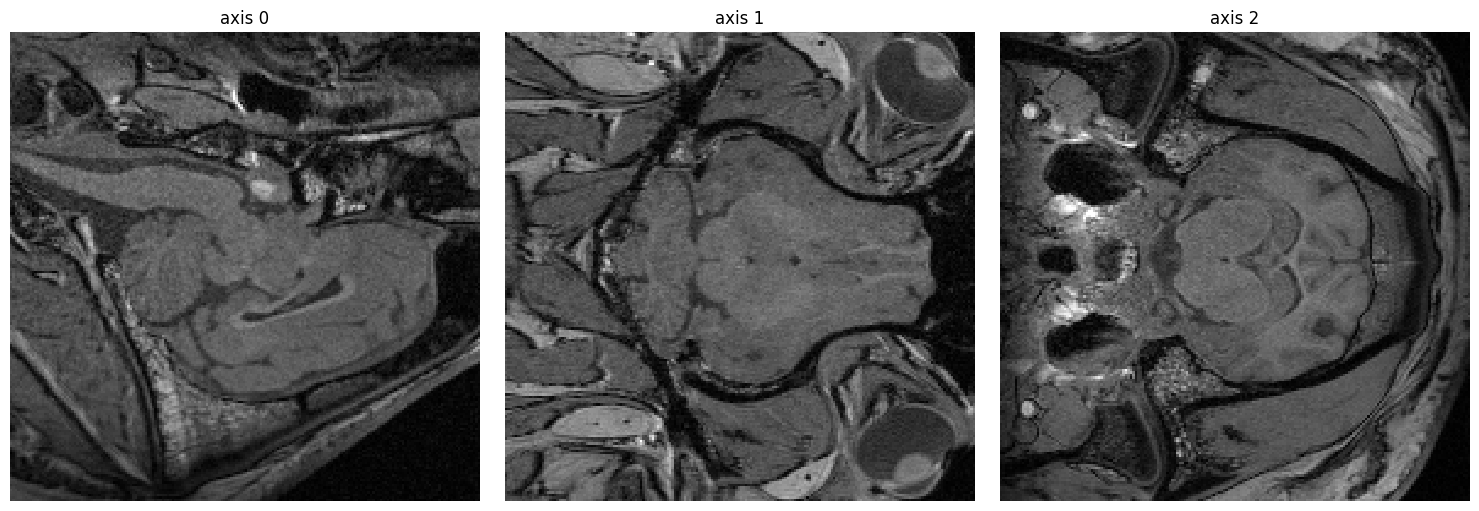

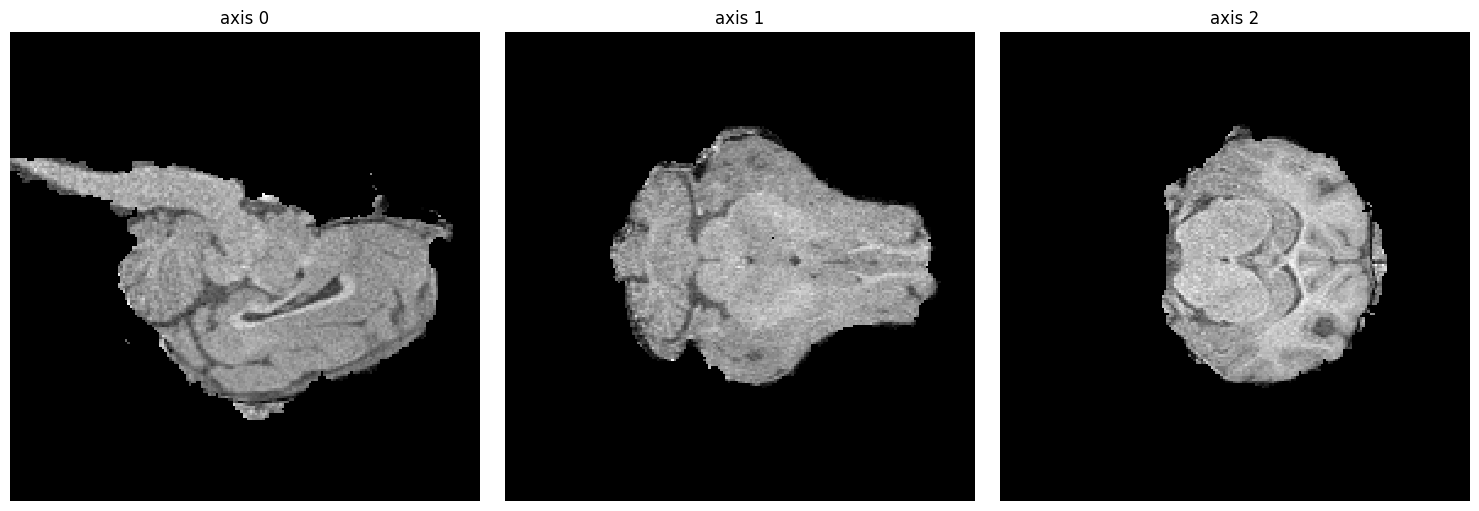

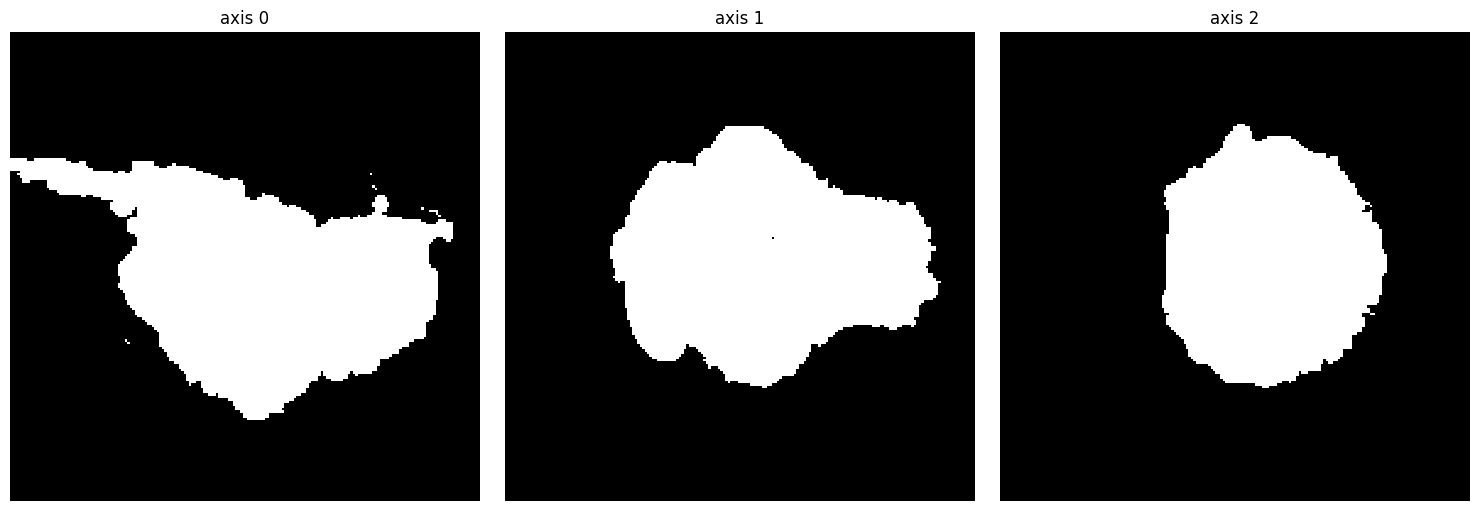

(<Figure size 1500x500 with 3 Axes>,
 [array([<AxesSubplot:title={'center':'axis 0'}>,
         <AxesSubplot:title={'center':'axis 1'}>,
         <AxesSubplot:title={'center':'axis 2'}>], dtype=object)])

In [8]:
folder_path = "/gpfs/fs001/cbica/home/dadashkj/upenn_pigAnatomical/template/"
geom_data = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).geom
pig_anat = sf.load_volume(os.path.join(folder_path, 'anat.nii.gz')).reshape([param_3d.img_size_192,]*3).data
 #sf.load_volume(os.path.join(folder_path, 'anat_brain.nii.gz')).reshape([param_3d.img_size_192,]*3).data
pig_brain_mask = sf.load_volume(os.path.join(folder_path, 'anat_brain_mask.nii.gz')).reshape([param_3d.img_size_192,]*3).data
pig_brain = pig_anat * (pig_brain_mask == 1)
ne.plot.volume3D(pig_anat)
ne.plot.volume3D(pig_brain)
ne.plot.volume3D(pig_brain_mask)

In [9]:
nib.save(nib.Nifti1Image(pig_brain.astype(np.int32), np.eye(4)),os.path.join(folder_path, 'anat_brain.nii.gz'))